In [39]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import cKDTree
from scipy.interpolate import splprep, splev, Rbf
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    balanced_accuracy_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier



### Preprocessing

In [7]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [8]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [9]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [10]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [11]:
# Window configuration in minutes
WINDOW_SIZE_MINUTES = 120  # 120 minutes of history
PREDICTION_LAG_MINUTES = 20  # Predict 20 minutes ahead
AGGREGATION_INTERVAL_MINUTES = 1  # Aggregate to 1-minute intervals

In [12]:
# Allow gaps in data
MIN_READINGS_IN_WINDOW = 80  # Require at least 80/120 minutes (67% coverage)
MIN_STATIONS_PER_READING = 3  # Require at least 3/8 stations per time point
MIN_STATIONS_AT_TARGET = 3  # Require at least 3/8 stations at prediction time

In [13]:
# Event configuration
MIN_EVENT_GAP_MINUTES = 30
MIN_EVENT_DURATION_MINUTES = 15

In [14]:
# Spatial configuration
CHANNEL_SPACING_METERS = 50
DEM_PATH = 'merged_swissalti3d.tif'

In [15]:
# PCA configuration
N_SPATIAL_COMPONENTS = 5

# Data split - CHANGED: No validation set, combine val+test into test
TRAIN_SPLIT = 0.70

print(f"  Data split: {TRAIN_SPLIT*100:.0f}% train, {(1-TRAIN_SPLIT)*100:.0f}% test (no validation set)")

  Data split: 70% train, 30% test (no validation set)


In [16]:
# LOAD AND AGGREGATE DATA TO MINUTE LEVEL


# Assuming df_merged is already loaded
df = df_merged.copy()
df['time'] = pd.to_datetime(df['time'])

print(f"\nOriginal data shape: {df.shape}")
print(f"Original time range: {df['time'].min()} to {df['time'].max()}")
print(f"Original time resolution: ~50 seconds (unaligned)")

# minute-level timestamp
df['time_minute'] = df['time'].dt.floor('1min')

print(f"\nAggregating to minute level...")
print("  Method: Taking max anomaly_score per station per minute")

# Aggregate to minute level
df_minute = df.groupby(['station', 'time_minute']).agg({
    'anomaly_score': 'max',
    'std': 'mean',
    'debris flow': 'max',
    'Station': 'first',
    'Latitude': 'first',
    'Longitude': 'first',
    'Elevation': 'first',
    'X_mn95': 'first',
    'Y_mn95': 'first'
}).reset_index()

df_minute = df_minute.rename(columns={'time_minute': 'time'})
df_minute = df_minute.sort_values(['time', 'station']).reset_index(drop=True)

print(f"\nAggregated data shape: {df_minute.shape}")
print(f"Data reduction: {len(df)} → {len(df_minute)} ({len(df_minute)/len(df)*100:.1f}%)")
print(f"Time resolution: 1 minute (ALIGNED across all stations)")

# Get station information
station_coords = df_minute[['station', 'X_mn95', 'Y_mn95', 'Elevation']].drop_duplicates('station')
station_coords = station_coords.sort_values('station').reset_index(drop=True)
station_coords.columns = ['station', 'X', 'Y', 'Z']

print(f"\nStations: {sorted(df_minute['station'].unique())}")
print(f"Debris flow readings: {(df_minute['debris flow'] == 1).sum()} / {len(df_minute)}")


Original data shape: (8274482, 11)
Original time range: 2018-05-14 11:03:29.650000 to 2022-08-28 21:22:22.730000
Original time resolution: ~50 seconds (unaligned)

Aggregating to minute level...
  Method: Taking max anomaly_score per station per minute

Aggregated data shape: (6896261, 11)
Data reduction: 8274482 → 6896261 (83.3%)
Time resolution: 1 minute (ALIGNED across all stations)

Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL14', 'ILL15', 'ILL16', 'ILL17', 'ILL18']
Debris flow readings: 18214 / 6896261


In [17]:
# Identify debris flow events
def identify_events(df, min_gap_minutes=MIN_EVENT_GAP_MINUTES):
    """Group continuous debris flow periods into discrete events."""
    df_debris = df[df['debris flow'] == 1].copy()
    df_debris = df_debris.sort_values('time')
    
    df_debris['time_diff_minutes'] = df_debris['time'].diff().dt.total_seconds() / 60
    df_debris['new_event'] = (df_debris['time_diff_minutes'] > min_gap_minutes) | \
                              (df_debris['time_diff_minutes'].isna())
    df_debris['event_id'] = df_debris['new_event'].cumsum()
    
    events = []
    for event_id, group in df_debris.groupby('event_id'):
        event_info = {
            'event_id': event_id,
            'start_time': group['time'].min(),
            'end_time': group['time'].max(),
            'duration_minutes': (group['time'].max() - group['time'].min()).total_seconds() / 60,
            'n_readings': len(group['time'].unique()),
            'stations_involved': sorted(group['station'].unique())
        }
        events.append(event_info)
    
    events_df = pd.DataFrame(events)
    event_mapping = df_debris[['time', 'station', 'event_id']].copy()
    
    return events_df, event_mapping

events_df, event_mapping = identify_events(df_minute)
df_minute = df_minute.merge(event_mapping, on=['time', 'station'], how='left')
df_minute['event_id'] = df_minute['event_id'].fillna(-1).astype(int)

print(f"\nIdentified {len(events_df)} debris flow events")
print(f"\nEvent duration statistics:")
print(events_df['duration_minutes'].describe())

valid_events = events_df[events_df['duration_minutes'] >= MIN_EVENT_DURATION_MINUTES].copy()
print(f"\nEvents with duration >= {MIN_EVENT_DURATION_MINUTES} min: {len(valid_events)}")


Identified 44 debris flow events

Event duration statistics:
count     44.000000
mean     129.022727
std       76.600288
min       15.000000
25%       72.750000
50%      102.000000
75%      181.750000
max      313.000000
Name: duration_minutes, dtype: float64

Events with duration >= 15 min: 44


In [18]:
# Create channel centerline from DEM
def create_channel_centerline(station_coords, dem_path=DEM_PATH, spacing=CHANNEL_SPACING_METERS):
    """Create interpolated points along channel."""
    stations_sorted = station_coords.sort_values('Z', ascending=False).reset_index(drop=True)
    
    print(f"Stations (top to bottom):")
    for _, row in stations_sorted.iterrows():
        print(f"  {row['station']}: elevation {row['Z']:.1f}m")
    
    tck, u = splprep(
        [stations_sorted['X'].values, 
         stations_sorted['Y'].values, 
         stations_sorted['Z'].values],
        s=0,
        k=min(3, len(stations_sorted)-1)
    )
    
    u_samples = np.linspace(0, 1, 100)
    x_samples, y_samples, z_samples = splev(u_samples, tck)
    path_length = np.sum(np.sqrt(np.diff(x_samples)**2 + np.diff(y_samples)**2 + np.diff(z_samples)**2))
    
    n_points = max(int(path_length / spacing), len(stations_sorted))
    
    print(f"\nChannel path length: ~{path_length:.0f}m")
    print(f"Sampling every {spacing}m → {n_points} points")
    
    u_fine = np.linspace(0, 1, n_points)
    X_channel, Y_channel, Z_channel_spline = splev(u_fine, tck)
    
    try:
        with rasterio.open(dem_path) as src:
            print(f"Extracting elevations from DEM: {dem_path}")
            coords = list(zip(X_channel, Y_channel))
            Z_channel_dem = np.array([val[0] for val in src.sample(coords)])
            Z_channel = np.where(np.isnan(Z_channel_dem), Z_channel_spline, Z_channel_dem)
            print(f" Successfully extracted DEM elevations")
    except Exception as e:
        print(f"Could not read DEM: {e}")
        Z_channel = Z_channel_spline
    
    distances = np.zeros(n_points)
    for i in range(1, n_points):
        distances[i] = distances[i-1] + np.sqrt(
            (X_channel[i] - X_channel[i-1])**2 + 
            (Y_channel[i] - Y_channel[i-1])**2 +
            (Z_channel[i] - Z_channel[i-1])**2
        )
    
    channel_df = pd.DataFrame({
        'point_id': range(n_points),
        'X': X_channel,
        'Y': Y_channel,
        'Z': Z_channel,
        'distance_from_top': distances
    })
    
    return channel_df, tck, stations_sorted

channel_points, spline_tck, stations_sorted = create_channel_centerline(station_coords)
print(f"\n✓ Created channel with {len(channel_points)} points")
print(f"  Elevation range: {channel_points['Z'].min():.1f}m to {channel_points['Z'].max():.1f}m")

Stations (top to bottom):
  ILL15: elevation 2384.5m
  ILL14: elevation 2195.3m
  ILL16: elevation 2041.6m
  ILL17: elevation 1959.5m
  ILL18: elevation 1449.0m
  ILL12: elevation 913.5m
  ILL13: elevation 735.1m
  ILL11: elevation 665.2m

Channel path length: ~10722m
Sampling every 50m → 214 points
Extracting elevations from DEM: merged_swissalti3d.tif
 Successfully extracted DEM elevations

✓ Created channel with 214 points
  Elevation range: 665.8m to 2533.5m


In [19]:
# Chronological Data Splitting, by event
valid_events = valid_events.sort_values('start_time').reset_index(drop=True)

n_events = len(valid_events)
n_train = int(n_events * TRAIN_SPLIT)
# No validation set - rest goes to test
n_test = n_events - n_train

train_event_ids = valid_events.iloc[:n_train]['event_id'].values
test_event_ids = valid_events.iloc[n_train:]['event_id'].values

print(f"\nEvent split (NO VALIDATION SET):")
print(f"  Training events: {len(train_event_ids)} ({n_train}/{n_events} = {n_train/n_events*100:.1f}%)")
print(f"    Event IDs: {list(train_event_ids[:5])}{'...' if len(train_event_ids) > 5 else ''}")
print(f"  Test events: {len(test_event_ids)} ({n_test}/{n_events} = {n_test/n_events*100:.1f}%)")
print(f"    Event IDs: {list(test_event_ids)}")

def get_event_data_with_buffer(df, event_id, buffer_minutes=10):
    """Get data for event plus buffer periods."""
    event_info = events_df[events_df['event_id'] == event_id].iloc[0]
    start_time = event_info['start_time'] - pd.Timedelta(minutes=buffer_minutes)
    end_time = event_info['end_time'] + pd.Timedelta(minutes=buffer_minutes)
    return df[(df['time'] >= start_time) & (df['time'] <= end_time)].copy()

train_data = pd.concat([get_event_data_with_buffer(df_minute, eid) for eid in train_event_ids])
test_data = pd.concat([get_event_data_with_buffer(df_minute, eid) for eid in test_event_ids])

print(f"\nData split sizes:")
print(f"  Training: {len(train_data)} readings")
print(f"  Test: {len(test_data)} readings")

# Verify no temporal overlap
assert train_data['time'].max() < test_data['time'].min(), "Train/Test temporal overlap!"



Event split (NO VALIDATION SET):
  Training events: 30 (30/44 = 68.2%)
    Event IDs: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]...
  Test events: 14 (14/44 = 31.8%)
    Event IDs: [np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44)]

Data split sizes:
  Training: 30073 readings
  Test: 15298 readings


In [20]:
# Sliding window features
def create_windows_with_gaps(data_df, station_coords, event_ids):
    """
    Create windows that tolerate missing data.
    
    1. Define a time RANGE (120 minutes)
    2. Collect all available data in that range
    3. Create a dense matrix with NaN for missing values
    4. Accept window if it has enough coverage
    """
    windows = []
    all_stations = sorted(station_coords['station'])
    n_stations = len(all_stations)
    
    for event_id in event_ids:
        event_data = data_df[data_df['event_id'] == event_id].copy()
        
        if len(event_data) == 0:
            continue
        
        # Get unique time points
        times = sorted(event_data['time'].unique())
        
        # Create sliding windows
        for i, target_time in enumerate(times):
            # Define time window: [target - lag - window_size, target - lag]
            window_end_time = target_time - pd.Timedelta(minutes=PREDICTION_LAG_MINUTES)
            window_start_time = window_end_time - pd.Timedelta(minutes=WINDOW_SIZE_MINUTES)
            
            # Get all data in this time range
            window_data = event_data[
                (event_data['time'] >= window_start_time) & 
                (event_data['time'] <= window_end_time)
            ]
            
            if len(window_data) == 0:
                continue
            
            # Count unique time points with data
            n_time_points_with_data = window_data['time'].nunique()
            
            # Check if we have enough coverage
            if n_time_points_with_data < MIN_READINGS_IN_WINDOW:
                continue
            
            # Create full time range (every minute)
            full_time_range = pd.date_range(
                start=window_start_time,
                end=window_end_time,
                freq='1min'
            )
            
            # Create empty matrix: rows = time points, cols = stations
            window_matrix = np.full((len(full_time_range), n_stations), np.nan)
            
            # Fill in available data
            for time_idx, time_point in enumerate(full_time_range):
                time_data = window_data[window_data['time'] == time_point]
                
                # Count stations at this time
                n_stations_at_time = len(time_data)
                
                # Fill in scores for available stations
                for _, row in time_data.iterrows():
                    station = row['station']
                    if station in all_stations:
                        station_idx = all_stations.index(station)
                        window_matrix[time_idx, station_idx] = row['anomaly_score']
            
            # Check if enough data points have sufficient station coverage
            n_stations_per_time = np.sum(~np.isnan(window_matrix), axis=1)
            n_good_times = np.sum(n_stations_per_time >= MIN_STATIONS_PER_READING)
            
            if n_good_times < MIN_READINGS_IN_WINDOW * 0.8:  # At least 80% of required readings have enough stations
                continue
            
            # Get target time data for ground truth
            target_data = event_data[event_data['time'] == target_time]
            n_stations_at_target = len(target_data)
            
            if n_stations_at_target < MIN_STATIONS_AT_TARGET:
                continue
            
            # Store window
            windows.append({
                'event_id': event_id,
                'time': target_time,
                'window_matrix': window_matrix,
                'target_data': target_data,
                'n_stations_at_target': n_stations_at_target,
                'coverage': n_time_points_with_data / WINDOW_SIZE_MINUTES,
                'n_time_points': n_time_points_with_data
            })
    
    return windows

print("Creating training windows...")
train_windows = create_windows_with_gaps(train_data, station_coords, train_event_ids)

print("Creating test windows...")
test_windows = create_windows_with_gaps(test_data, station_coords, test_event_ids)

print(f"\nWindow counts:")
print(f"  Training: {len(train_windows)} windows")
print(f"  Test: {len(test_windows)} windows")

if len(train_windows) > 0:
    train_coverages = [w['coverage'] for w in train_windows]
    print(f"\nTraining window coverage:")
    print(f"  Mean: {np.mean(train_coverages):.1%}")
    print(f"  Min: {np.min(train_coverages):.1%}")
    print(f"  Max: {np.max(train_coverages):.1%}")

if len(test_windows) > 0:
    test_coverages = [w['coverage'] for w in test_windows]
    print(f"\nTest window coverage:")
    print(f"  Mean: {np.mean(test_coverages):.1%}")
    print(f"  Min: {np.min(test_coverages):.1%}")
    print(f"  Max: {np.max(test_coverages):.1%}")
else:
    print("\n⚠️  no test windows - events may be too short or sparse")


Creating training windows...
Creating test windows...

Window counts:
  Training: 671 windows
  Test: 99 windows

Training window coverage:
  Mean: 95.2%
  Min: 66.7%
  Max: 100.8%

Test window coverage:
  Mean: 89.8%
  Min: 66.7%
  Max: 100.8%


In [28]:
# Ground truth labels
n_stations = len(stations_sorted)
n_pairs = n_stations - 1

def determine_head_station_pair_fixed(window):
    """Determine which station pair the head is between at TARGET time."""
    target_data = window['target_data']
    
    if len(target_data) == 0:
        return None
    
    station_to_score = {}
    for _, row in target_data.iterrows():
        station_to_score[row['station']] = row['anomaly_score']
    
    stations_sorted_list = stations_sorted['station'].tolist()
    sorted_scores = []
    for station in stations_sorted_list:
        if station in station_to_score:
            sorted_scores.append(station_to_score[station])
        else:
            sorted_scores.append(0.0)
    
    sorted_scores = np.array(sorted_scores)
    max_idx = np.argmax(sorted_scores)
    
    if max_idx == 0:
        pair_idx = 0
    elif max_idx == n_stations - 1:
        pair_idx = n_pairs - 1
    else:
        score_downstream = sorted_scores[max_idx + 1] if max_idx < n_stations - 1 else 0
        score_upstream = sorted_scores[max_idx - 1] if max_idx > 0 else 0
        
        if score_downstream > score_upstream:
            pair_idx = max_idx
        else:
            pair_idx = max_idx - 1
    
    return pair_idx, sorted_scores, max_idx


for split_name, windows in [('train', train_windows), ('test', test_windows)]:
    valid_windows = []
    diagnostic_info = []
    
    for window in windows:
        result = determine_head_station_pair_fixed(window)
        if result is not None:
            pair_idx, sorted_scores, max_idx = result
            window['head_pair'] = pair_idx
            valid_windows.append(window)
            
            if len(diagnostic_info) < 2:
                diagnostic_info.append({
                    'time': window['time'],
                    'n_stations': window['n_stations_at_target'],
                    'coverage': window['coverage'],
                    'scores': sorted_scores,
                    'max_station_idx': max_idx,
                    'pair': pair_idx
                })
    
    if split_name == 'train':
        train_windows = valid_windows
    else:
        test_windows = valid_windows
    
    print(f"\n{split_name.capitalize()} set:")
    print(f"  Total windows: {len(valid_windows)}")
    
    if len(valid_windows) > 0:
        pair_counts = pd.Series([w['head_pair'] for w in valid_windows]).value_counts().sort_index()
        print(f"  Pair distribution:")
        for pair, count in pair_counts.items():
            print(f"    Pair {pair}: {count} samples ({count/len(valid_windows)*100:.1f}%)")
        
        if len(diagnostic_info) > 0:
            print(f"\n  Example labeled windows:")
            for i, info in enumerate(diagnostic_info):
                print(f"    Window {i+1}:")
                print(f"      Time: {info['time']}")
                print(f"      Stations: {info['n_stations']}/8")
                print(f"      Coverage: {info['coverage']:.1%}")
                print(f"      Scores: {info['scores'].round(3)}")
                print(f"      Pair: {info['pair']}")



Train set:
  Total windows: 274
  Pair distribution:
    Pair 3: 54 samples (19.7%)
    Pair 4: 62 samples (22.6%)
    Pair 5: 34 samples (12.4%)
    Pair 6: 124 samples (45.3%)

  Example labeled windows:
    Window 1:
      Time: 2019-06-11 00:01:00
      Stations: 4/8
      Coverage: 100.8%
      Scores: [0.    0.    0.    0.529 0.66  0.665 0.    0.694]
      Pair: 6
    Window 2:
      Time: 2020-08-30 07:31:00
      Stations: 4/8
      Coverage: 95.0%
      Scores: [0.586 0.    0.59  0.597 0.684 0.    0.    0.   ]
      Pair: 3

Test set:
  Total windows: 99
  Pair distribution:
    Pair 4: 15 samples (15.2%)
    Pair 5: 4 samples (4.0%)
    Pair 6: 80 samples (80.8%)

  Example labeled windows:
    Window 1:
      Time: 2021-07-13 16:34:00
      Stations: 6/8
      Coverage: 66.7%
      Scores: [0.    0.    0.599 0.615 0.719 0.765 0.698 0.717]
      Pair: 4
    Window 2:
      Time: 2021-07-13 16:35:00
      Stations: 6/8
      Coverage: 67.5%
      Scores: [0.    0.    0.615 0.

In [29]:
# Balance classes with undersampling
from sklearn.utils import resample
import random


# Separate training windows by class
windows_by_pair = {}
unique_pairs = sorted(set([w['head_pair'] for w in train_windows]))

for pair in unique_pairs:
    windows_by_pair[pair] = [w for w in train_windows if w['head_pair'] == pair]

print("\nOriginal training distribution:")
for pair in sorted(windows_by_pair.keys()):
    print(f"  Pair {pair}: {len(windows_by_pair[pair])} samples ({len(windows_by_pair[pair])/len(train_windows)*100:.1f}%)")

# Calculate imbalance ratio
counts = [len(windows_by_pair[p]) for p in windows_by_pair.keys()]
imbalance_ratio = max(counts) / min(counts)
print(f"\nImbalance ratio: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 3.0:
    print(" Severe imbalance - applying undersampling...")
    
    # Find minority classes (not the max)
    max_pair = max(windows_by_pair.keys(), key=lambda p: len(windows_by_pair[p]))
    minority_pairs = [p for p in windows_by_pair.keys() if p != max_pair]
    
    # Target size: 2x the largest minority class
    if len(minority_pairs) > 0:
        max_minority = max(len(windows_by_pair[p]) for p in minority_pairs)
        target_size = min(max_minority * 2, len(windows_by_pair[max_pair]))
        
        print(f"\nUndersampling Pair {max_pair} from {len(windows_by_pair[max_pair])} to {target_size} samples")
        
        # Undersample the majority class
        windows_by_pair[max_pair] = resample(
            windows_by_pair[max_pair],
            n_samples=target_size,
            random_state=42,
            replace=False
        )
        
        # Recombine all windows
        train_windows = []
        for pair in sorted(windows_by_pair.keys()):
            train_windows.extend(windows_by_pair[pair])
        
        # Shuffle to mix classes
        random.seed(42)
        random.shuffle(train_windows)
        
        print(f"\nBalanced training distribution:")
        for pair in sorted(windows_by_pair.keys()):
            count = sum(1 for w in train_windows if w['head_pair'] == pair)
            print(f"  Pair {pair}: {count} samples ({count/len(train_windows)*100:.1f}%)")
        
        # Recalculate imbalance
        new_counts = [sum(1 for w in train_windows if w['head_pair'] == p) for p in windows_by_pair.keys()]
        new_imbalance = max(new_counts) / min(new_counts)
        print(f"\nNew imbalance ratio: {new_imbalance:.1f}:1")
        print(f"Total training windows: {len(train_windows)} (reduced from {sum(counts)})")
    else:
        print("Only one class present - cannot balance")
else:
    print("Classes already balanced (ratio < 3:1)")

print(f"\nFinal training set size: {len(train_windows)} windows")


Original training distribution:
  Pair 3: 54 samples (19.7%)
  Pair 4: 62 samples (22.6%)
  Pair 5: 34 samples (12.4%)
  Pair 6: 124 samples (45.3%)

Imbalance ratio: 3.6:1
 Severe imbalance - applying undersampling...

Undersampling Pair 6 from 124 to 124 samples

Balanced training distribution:
  Pair 3: 54 samples (19.7%)
  Pair 4: 62 samples (22.6%)
  Pair 5: 34 samples (12.4%)
  Pair 6: 124 samples (45.3%)

New imbalance ratio: 3.6:1
Total training windows: 274 (reduced from 274)

Final training set size: 274 windows


In [23]:
# Feature creation
def create_enhanced_features_with_nan(window_matrix):
    """
    Create enhanced features that handle NaN values.
    
    - Use nanmean, nanmax, etc. for aggregations
    - Add features about missingness (how much data is missing)
    """
    # Handle NaN by using nan-aware functions
    with np.errstate(invalid='ignore'):  # Suppress warnings for all-NaN slices
        # Basic temporal features (last available)
        last_reading = window_matrix[-1]
        first_reading = window_matrix[0]
        
        # Find middle non-NaN reading
        non_nan_rows = np.where(~np.all(np.isnan(window_matrix), axis=1))[0]
        if len(non_nan_rows) > 0:
            mid_idx = non_nan_rows[len(non_nan_rows)//2]
            mid_reading = window_matrix[mid_idx]
        else:
            mid_reading = np.full(window_matrix.shape[1], 0.0)
        
        # Movement features (handle NaN)
        score_changes = np.nan_to_num(last_reading - first_reading, nan=0.0)
        score_velocity = score_changes / len(window_matrix)
        
        # Spatial gradient
        spatial_gradient = np.diff(np.nan_to_num(last_reading, nan=0.0))
        
        # Aggregate statistics (nan-aware)
        max_station_last = np.nanargmax(last_reading) if not np.all(np.isnan(last_reading)) else 0
        max_station_first = np.nanargmax(first_reading) if not np.all(np.isnan(first_reading)) else 0
        max_value_last = np.nanmax(last_reading) if not np.all(np.isnan(last_reading)) else 0.0
        max_value_first = np.nanmax(first_reading) if not np.all(np.isnan(first_reading)) else 0.0
        
        # Missing data features
        missing_last = np.sum(np.isnan(last_reading)) / len(last_reading)
        missing_first = np.sum(np.isnan(first_reading)) / len(first_reading)
        missing_overall = np.sum(np.isnan(window_matrix)) / window_matrix.size
        
        # Replace NaN with 0 for concatenation
        last_reading_clean = np.nan_to_num(last_reading, nan=0.0)
        first_reading_clean = np.nan_to_num(first_reading, nan=0.0)
        mid_reading_clean = np.nan_to_num(mid_reading, nan=0.0)
        
        # Combine all features
        enhanced_features = np.concatenate([
            last_reading_clean,      # 8 features
            first_reading_clean,     # 8 features
            mid_reading_clean,       # 8 features
            score_changes,           # 8 features
            score_velocity,          # 8 features
            spatial_gradient,        # 7 features
            [max_station_last],      # 1 feature
            [max_station_first],     # 1 feature
            [max_value_last],        # 1 feature
            [max_value_first],       # 1 feature
            [max_station_last - max_station_first],  # 1 feature
            [missing_last],          # 1 feature 
            [missing_first],         # 1 feature 
            [missing_overall]        # 1 feature 
        ])
    
    return enhanced_features


def prepare_enhanced_data_with_nan(windows):
    """Prepare data handling NaN values in window matrices."""
    # For temporal input, impute NaN values
    X_temporal_list = []
    for w in windows:
        window_matrix = w['window_matrix'].copy()
        # Impute NaN with 0 (representing no anomaly/missing sensor)
        window_matrix_clean = np.nan_to_num(window_matrix, nan=0.0)
        X_temporal_list.append(window_matrix_clean)
    
    X_temporal = np.array(X_temporal_list)
    X_enhanced = np.array([create_enhanced_features_with_nan(w['window_matrix']) for w in windows])
    y = np.array([w['head_pair'] for w in windows])
    return X_temporal, X_enhanced, y

X_train_temporal, X_train_enhanced, y_train = prepare_enhanced_data_with_nan(train_windows)

if len(test_windows) > 0:
    X_test_temporal, X_test_enhanced, y_test = prepare_enhanced_data_with_nan(test_windows)
else:
    X_test_temporal, X_test_enhanced, y_test = None, None, None

print(f"\nFeature shapes:")
print(f"  Temporal features: {X_train_temporal.shape}")
print(f"  Enhanced features: {X_train_enhanced.shape}")
print(f"  Labels: {y_train.shape}")

if X_test_temporal is not None:
    print(f"  Test temporal features: {X_test_temporal.shape}")
    print(f"  Test enhanced features: {X_test_enhanced.shape}")
    print(f"  Test labels: {y_test.shape}")

# Check for any remaining NaN
print(f"\nNaN check in training data:")
print(f"  Temporal: {np.isnan(X_train_temporal).sum()} NaNs")
print(f"  Enhanced: {np.isnan(X_train_enhanced).sum()} NaNs")


Feature shapes:
  Temporal features: (274, 121, 8)
  Enhanced features: (274, 55)
  Labels: (274,)
  Test temporal features: (99, 121, 8)
  Test enhanced features: (99, 55)
  Test labels: (99,)

NaN check in training data:
  Temporal: 0 NaNs
  Enhanced: 0 NaNs


### Neural Network


Model architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ temporal_input      │ (None, 121, 8)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enhanced_input      │ (None, 55)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 121, 64)   │     18,688 │ temporal_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      3,584 │ enhanced_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 121, 64)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      1,056 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │        528 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 7)         │        119 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 39,527 (154.40 KB)

 Trainable params: 39,527 (154.40 KB)

 Non-trainable params: 0 (0.00 B)


Balanced class weights:
  Pair 0: 1.27
  Pair 1: 1.10
  Pair 2: 2.01
  Pair 3: 0.55

Starting training
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.0548 - loss: 1.8289 - val_accuracy: 0.0000e+00 - val_loss: 1.9636 - learning_rate: 5.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1187 - loss: 1.7606 - val_accuracy: 0.1455 - val_loss: 1.9270 - learning_rate: 5.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1689 - loss: 1.7247 - val_accuracy: 0.2182 - val_loss: 1.8984 - learning_rate: 5.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2603 - loss: 1.6768 - val_accuracy: 0.2727 - val_loss: 1.8690 - learning_rate: 5.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3105 - loss: 1.6290 - val_accuracy: 0.2909 - val_loss: 1.8387 - learning_rate: 5.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3927 - loss: 1.5597 - val_accuracy: 0.3091 - val_loss: 1.8070 -

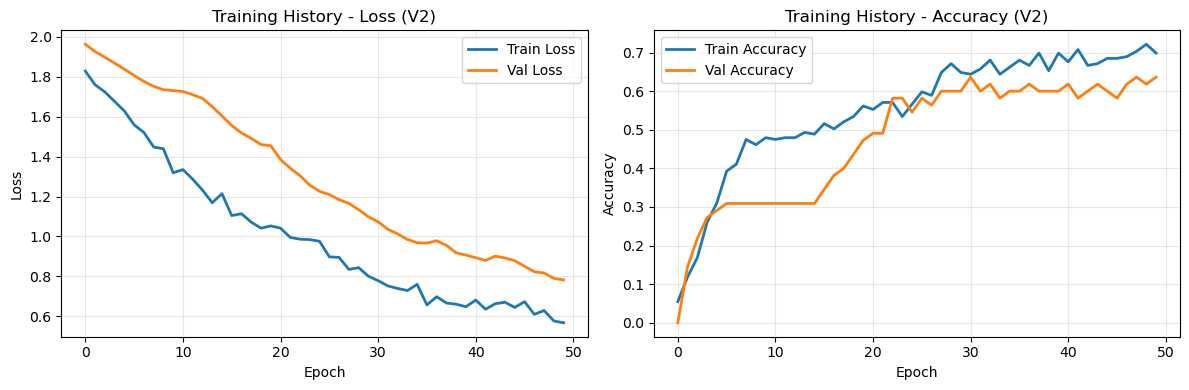


Final dataset sizes:
  Training: 274 windows
  Test: 99 windows
  Total: 373 windows

 Test windows created

Test set class distribution:
  Pair 4: 15 samples (15.2%)
  Pair 5: 4 samples (4.0%)
  Pair 6: 80 samples (80.8%)

 Class diversity: 3 classes in test set


In [31]:
# NN model -  version with LSTM and Dense layers

keras.backend.clear_session()

def build_improved_model(temporal_shape, enhanced_shape, n_classes):
    """Two-stream model: LSTM + Dense"""
    # Stream 1: Temporal LSTM
    temporal_input = keras.layers.Input(shape=temporal_shape, name='temporal_input')
    x = keras.layers.LSTM(64, return_sequences=True)(temporal_input)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.LSTM(32)(x)
    x = keras.layers.Dropout(0.3)(x)
    temporal_features = keras.layers.Dense(16, activation='relu')(x)
    
    # Stream 2: Enhanced features
    enhanced_input = keras.layers.Input(shape=(enhanced_shape,), name='enhanced_input')
    y = keras.layers.Dense(64, activation='relu')(enhanced_input)
    y = keras.layers.Dropout(0.3)(y)
    y = keras.layers.Dense(32, activation='relu')(y)
    y = keras.layers.Dropout(0.3)(y)
    enhanced_features = keras.layers.Dense(16, activation='relu')(y)
    
    # Combine streams
    combined = keras.layers.Concatenate()([temporal_features, enhanced_features])
    combined = keras.layers.Dense(32, activation='relu')(combined)
    combined = keras.layers.Dropout(0.2)(combined)
    combined = keras.layers.Dense(16, activation='relu')(combined)
    
    # Output
    output = keras.layers.Dense(n_classes, activation='softmax', name='output')(combined)
    
    model = keras.Model(inputs=[temporal_input, enhanced_input], outputs=output)
    return model

model = build_improved_model(
    temporal_shape=X_train_temporal.shape[1:],
    enhanced_shape=X_train_enhanced.shape[1],
    n_classes=n_pairs
)

print("\nModel architecture:")
model.summary()

# Compute balanced class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

print(f"\nBalanced class weights:")
for i, weight in class_weights_dict.items():
    print(f"  Pair {i}: {weight:.2f}")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks - NO VALIDATION SET, use 20% of training for validation
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

print("\nStarting training")
history = model.fit(
    [X_train_temporal, X_train_enhanced],
    y_train,
    validation_split=0.2,  # Use 20% of training for validation
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n Training complete")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
if 'val_loss' in history.history:
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training History - Loss (V2)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
if 'val_accuracy' in history.history:
    ax.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training History - Accuracy (V2)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_v2.pdf', dpi=300)
plt.show()


print(f"\nFinal dataset sizes:")
print(f"  Training: {len(train_windows)} windows")
print(f"  Test: {len(test_windows)} windows")
print(f"  Total: {len(train_windows) + len(test_windows)} windows")

if len(test_windows) > 0:
    print("\n Test windows created")
    print(f"\nTest set class distribution:")
    test_pairs = pd.Series([w['head_pair'] for w in test_windows]).value_counts().sort_index()
    for pair, count in test_pairs.items():
        print(f"  Pair {pair}: {count} samples ({count/len(test_windows)*100:.1f}%)")
    
    n_test_classes = len(test_pairs)
    if n_test_classes == 1:
        print("\n  WARNING: Test set still has only 1 class!")
    elif n_test_classes >= 3:
        print(f"\n Class diversity: {n_test_classes} classes in test set")
    
else:
    print("\n WARNING: No test windows!")


##### NN Model Evaluation

In [35]:
# Check station ordering and pairs

print("\nStations sorted by elevation (top to bottom):")
for idx, (_, row) in enumerate(stations_sorted.iterrows()):
    print(f"  Index {idx}: {row['station']} at {row['Z']:.1f}m")

print(f"\nStation pairs (n_pairs = {n_pairs}):")
for i in range(n_pairs):
    station_up = stations_sorted.iloc[i]['station']
    station_down = stations_sorted.iloc[i+1]['station']
    print(f"  Pair {i}: Between {station_up} and {station_down}")

print("\nDebris flow path (top to bottom):")
path = " → ".join(stations_sorted['station'].tolist())
print(f"  {path}")

# Classes present

print("\nClasses present in each dataset:")
print(f"  Training: {sorted(np.unique(y_train))} (n={len(np.unique(y_train))})")

if y_test is not None:
    print(f"  Test: {sorted(np.unique(y_test))} (n={len(np.unique(y_test))})")

# Get all unique classes across all splits
all_classes = sorted(set(list(y_train) + 
                         (list(y_test) if y_test is not None else []) +
                         (list(y_test) if y_test is not None else [])))
print(f"\nAll classes present: {all_classes}")
print(f"Total unique classes: {len(all_classes)}")

# Create class names only for classes that actually exist
class_names = [f'Pair {i}' for i in all_classes]


Stations sorted by elevation (top to bottom):
  Index 0: ILL15 at 2384.5m
  Index 1: ILL14 at 2195.3m
  Index 2: ILL16 at 2041.6m
  Index 3: ILL17 at 1959.5m
  Index 4: ILL18 at 1449.0m
  Index 5: ILL12 at 913.5m
  Index 6: ILL13 at 735.1m
  Index 7: ILL11 at 665.2m

Station pairs (n_pairs = 7):
  Pair 0: Between ILL15 and ILL14
  Pair 1: Between ILL14 and ILL16
  Pair 2: Between ILL16 and ILL17
  Pair 3: Between ILL17 and ILL18
  Pair 4: Between ILL18 and ILL12
  Pair 5: Between ILL12 and ILL13
  Pair 6: Between ILL13 and ILL11

Debris flow path (top to bottom):
  ILL15 → ILL14 → ILL16 → ILL17 → ILL18 → ILL12 → ILL13 → ILL11

Classes present in each dataset:
  Training: [np.int64(3), np.int64(4), np.int64(5), np.int64(6)] (n=4)
  Test: [np.int64(4), np.int64(5), np.int64(6)] (n=3)

All classes present: [np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Total unique classes: 4



Overall Metrics:
  Accuracy: 0.7044 (70.44%)
  Balanced Accuracy: 0.6669 (66.69%)
  F1-Score (macro): 0.6036
  F1-Score (weighted): 0.6287
\ Classification Report:
              precision    recall  f1-score   support

      Pair 3       0.00      0.00      0.00        54
      Pair 4       0.82      0.98      0.90        62
      Pair 5       0.74      0.85      0.79        34
      Pair 6       0.64      0.83      0.72       124

    accuracy                           0.70       274
   macro avg       0.55      0.67      0.60       274
weighted avg       0.57      0.70      0.63       274


Confusion Matrix:
Classes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
[[  0   0   0  54]
 [  0  61   1   0]
 [  0   1  29   4]
 [  0  12   9 103]]

TEST SET PERFORMANCE

Overall Metrics:
  Accuracy: 0.6566 (65.66%)
  Balanced Accuracy: 0.3500 (35.00%)
  F1-Score (macro): 0.3060
  F1-Score (weighted): 0.6966

Detailed Classification Report:
              precision    recall  f1-score   s

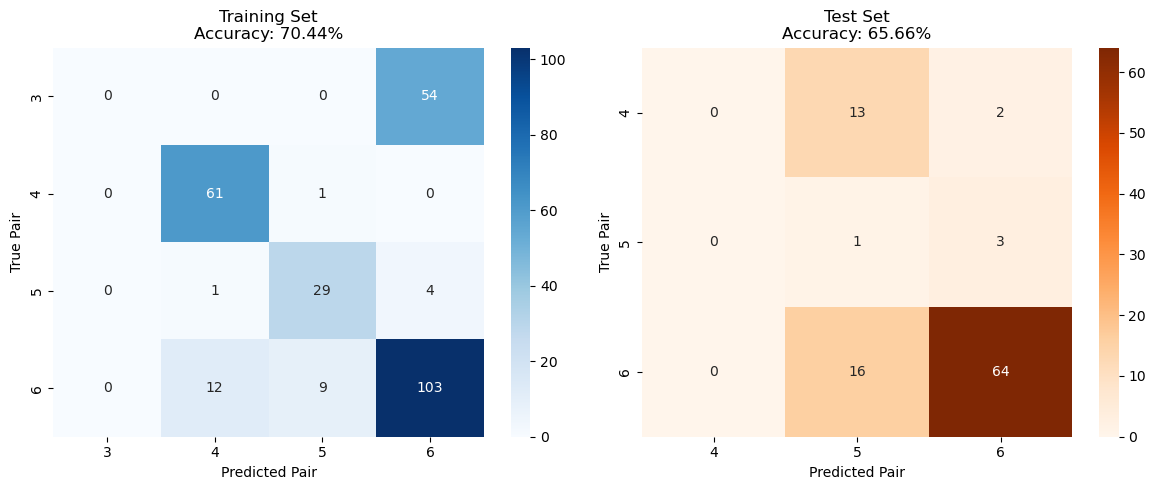

Class Imbalance Analysis

Training Set:
  Pair 3 (ILL17→ILL18):   54 samples ( 19.7%)
  Pair 4 (ILL18→ILL12):   62 samples ( 22.6%)
  Pair 5 (ILL12→ILL13):   34 samples ( 12.4%)
  Pair 6 (ILL13→ILL11):  124 samples ( 45.3%)

Test Set:
  Pair 4 (ILL18→ILL12):   15 samples ( 15.2%)
  Pair 5 (ILL12→ILL13):    4 samples (  4.0%)
  Pair 6 (ILL13→ILL11):   80 samples ( 80.8%)
  Severe imbalance detected. Max/Min ratio: 20.0x

 KEY RESULTS:
  Training Accuracy: 70.44%
  Test Accuracy: 65.66%

 Class Distribution Issues:
   Test set has limited class diversity: only 3 classes


In [38]:
# EVALUATE ON TRAINING SET


y_train_pred = model.predict([X_train_temporal, X_train_enhanced], verbose=0)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

train_accuracy = accuracy_score(y_train, y_train_pred_classes)
train_balanced_accuracy = balanced_accuracy_score(y_train, y_train_pred_classes)

# Only compute F1 for classes that exist
train_f1_macro = f1_score(y_train, y_train_pred_classes, average='macro', zero_division=0)
train_f1_weighted = f1_score(y_train, y_train_pred_classes, average='weighted', zero_division=0)

print(f"\nOverall Metrics:")
print(f"  Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  Balanced Accuracy: {train_balanced_accuracy:.4f} ({train_balanced_accuracy*100:.2f}%)")
print(f"  F1-Score (macro): {train_f1_macro:.4f}")
print(f"  F1-Score (weighted): {train_f1_weighted:.4f}")

print(f"\ Classification Report:")
# Use labels parameter to only include classes present in data
print(classification_report(
    y_train, 
    y_train_pred_classes,
    labels=all_classes,
    target_names=class_names,
    zero_division=0
))

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred_classes, labels=all_classes)
print(f"\nConfusion Matrix:")
print(f"Classes: {all_classes}")
print(cm_train)



# EVALUATE ON TEST SET


if X_test_temporal is not None and len(X_test_temporal) > 0:
    print("\n" + "="*70)
    print("TEST SET PERFORMANCE")
    print("="*70)
    
    y_test_pred = model.predict([X_test_temporal, X_test_enhanced], verbose=0)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    
    test_accuracy = accuracy_score(y_test, y_test_pred_classes)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred_classes)
    test_f1_macro = f1_score(y_test, y_test_pred_classes, average='macro', zero_division=0)
    test_f1_weighted = f1_score(y_test, y_test_pred_classes, average='weighted', zero_division=0)
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Balanced Accuracy: {test_balanced_accuracy:.4f} ({test_balanced_accuracy*100:.2f}%)")
    print(f"  F1-Score (macro): {test_f1_macro:.4f}")
    print(f"  F1-Score (weighted): {test_f1_weighted:.4f}")
    
    print(f"\nDetailed Classification Report:")
    test_classes = sorted(np.unique(y_test))
    test_class_names = [f'Pair {i}' for i in test_classes]
    
    # Check if test set has only one class
    if len(test_classes) == 1:
        print(f"\n WARNING: Test set contains only ONE class (Pair {test_classes[0]})!")

    else:
        print(classification_report(
            y_test, 
            y_test_pred_classes,
            labels=test_classes,
            target_names=test_class_names,
            zero_division=0
        ))
        
        # Confusion matrix
        cm_test = confusion_matrix(y_test, y_test_pred_classes, labels=test_classes)
        print(f"\nConfusion Matrix:")
        print(f"Classes: {test_classes}")
        print(cm_test)
    
    test_classes_var = test_classes
else:
    print("\n No test set available (0 windows created)")
    test_accuracy = None
    cm_test = None
    test_classes_var = None

 
# SUMMARY TABLE


summary_data = {
    'Dataset': [],
    'N_Samples': [],
    'N_Classes': [],
    'Accuracy': [],
    'Balanced_Acc': [],
    'F1_Macro': [],
    'F1_Weighted': []
}

# Training
summary_data['Dataset'].append('Training')
summary_data['N_Samples'].append(len(y_train))
summary_data['N_Classes'].append(len(np.unique(y_train)))
summary_data['Accuracy'].append(f"{train_accuracy:.4f}")
summary_data['Balanced_Acc'].append(f"{train_balanced_accuracy:.4f}")
summary_data['F1_Macro'].append(f"{train_f1_macro:.4f}")
summary_data['F1_Weighted'].append(f"{train_f1_weighted:.4f}")

# Test
if test_accuracy is not None:
    summary_data['Dataset'].append('Test')
    summary_data['N_Samples'].append(len(y_test))
    summary_data['N_Classes'].append(len(np.unique(y_test)))
    summary_data['Accuracy'].append(f"{test_accuracy:.4f}")
    summary_data['Balanced_Acc'].append(f"{test_balanced_accuracy:.4f}")
    summary_data['F1_Macro'].append(f"{test_f1_macro:.4f}")
    summary_data['F1_Weighted'].append(f"{test_f1_weighted:.4f}")

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))


# SAMPLE PREDICTION ANALYSIS

print("Sample Prediction Analysis:")

if test_accuracy is not None and len(test_classes_var) > 1:
    print("\nShowing first 5 test predictions:")
    for i in range(min(5, len(y_test))):
        true_pair = y_test[i]
        pred_pair = y_test_pred_classes[i]
        confidence = y_test_pred[i, pred_pair]
        
        # Get station names for this pair
        station_up = stations_sorted.iloc[pred_pair]['station']
        station_down = stations_sorted.iloc[pred_pair+1]['station']
        
        correct = "✓" if true_pair == pred_pair else "✗"
        print(f"  {i+1}. True: Pair {true_pair} | Pred: Pair {pred_pair} ({station_up}→{station_down}) | Conf: {confidence:.3f} {correct}")
elif test_accuracy is not None:
    print("\n Test set has only one class - showing sample predictions:")
    print(f"  All {len(y_test)} samples are Pair {test_classes_var[0]}")
    print(f"  Model prediction for first sample:")
    pred_pair = y_test_pred_classes[0]
    confidence = y_test_pred[0, pred_pair]
    station_up = stations_sorted.iloc[pred_pair]['station']
    station_down = stations_sorted.iloc[pred_pair+1]['station']
    print(f"    Predicted: Pair {pred_pair} ({station_up}→{station_down}) with confidence {confidence:.3f}")


# VISUALIZATIONS

# Determine how many confusion matrices to plot
n_plots = 1  # Training always exists
if test_accuracy is not None and len(test_classes_var) > 1:
    n_plots += 1

fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
if n_plots == 1:
    axes = [axes]

plot_idx = 0

# Plot training confusion matrix
ax = axes[plot_idx]
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
ax.set_xlabel('Predicted Pair')
ax.set_ylabel('True Pair')
ax.set_title(f'Training Set\nAccuracy: {train_accuracy:.2%}')
ax.set_xticklabels(all_classes)
ax.set_yticklabels(all_classes)
plot_idx += 1

# Plot test confusion matrix (only if more than 1 class)
if test_accuracy is not None and len(test_classes_var) > 1:
    ax = axes[plot_idx]
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=ax, cbar=True)
    ax.set_xlabel('Predicted Pair')
    ax.set_ylabel('True Pair')
    ax.set_title(f'Test Set\nAccuracy: {test_accuracy:.2%}')
    ax.set_xticklabels(test_classes_var)
    ax.set_yticklabels(test_classes_var)

plt.tight_layout()
plt.savefig('confusion_matrices_fixed.pdf', dpi=300)
plt.show()

# CLASS IMBALANCE ANALYSIS

print("Class Imbalance Analysis")


def analyze_class_distribution(y, dataset_name):
    """Analyze and visualize class distribution."""
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    
    print(f"\n{dataset_name}:")
    for pair, count in zip(unique, counts):
        station_up = stations_sorted.iloc[pair]['station']
        station_down = stations_sorted.iloc[pair+1]['station']
        print(f"  Pair {pair} ({station_up}→{station_down}): {count:4d} samples ({count/total*100:5.1f}%)")
    
    # Check for severe imbalance
    max_ratio = counts.max() / counts.min() if len(counts) > 1 else 1
    if max_ratio > 10:
        print(f"  Severe imbalance detected. Max/Min ratio: {max_ratio:.1f}x")

analyze_class_distribution(y_train, "Training Set")
if y_test is not None:
    analyze_class_distribution(y_test, "Test Set")

# FINAL SUMMARY


print("\n KEY RESULTS:")
print(f"  Training Accuracy: {train_accuracy*100:.2f}%")
if test_accuracy is not None:
    if len(test_classes_var) > 1:
        print(f"  Test Accuracy: {test_accuracy*100:.2f}%")

    else:
        print(f" Test Accuracy: N/A (only 1 class present)")

print("\n Class Distribution Issues:")
if y_test is not None and len(test_classes_var) == 1:
    print("  CRITICAL: Test set contains only ONE class!")
    print(f"     All {len(y_test)} test samples are Pair {test_classes_var[0]}")
elif y_test is not None:
    n_test_classes = len(test_classes_var)
    if n_test_classes < 4:
        print(f"   Test set has limited class diversity: only {n_test_classes} classes")
    else:
        print(f"  Good test set: {n_test_classes} classes present")

# Check training class imbalance
train_unique, train_counts = np.unique(y_train, return_counts=True)
if len(train_counts) > 1 and train_counts.max() / train_counts.min() > 10:
    print(" Training set has severe class imbalance (>10:1 ratio)")


#### Pair Prediction with RF
Same preprocessing as above

In [41]:
# RF Model

# Prepare data (no need for temporal features with Random Forest)
print("  Using: Enhanced features only (not temporal sequences)")


# Enhanced features already created - just ensure they're ready
print(f"\nFeature shapes:")
print(f"  Training features: {X_train_enhanced.shape}")
print(f"  Training labels: {y_train.shape}")
if X_test_enhanced is not None:
    print(f"  Test features: {X_test_enhanced.shape}")
    print(f"  Test labels: {y_test.shape}")

# Check for NaN values
n_nans_train = np.isnan(X_train_enhanced).sum()
n_nans_test = np.isnan(X_test_enhanced).sum() if X_test_enhanced is not None else 0

if n_nans_train > 0 or n_nans_test > 0:
    print(f"\n Found NaN values: {n_nans_train} in train, {n_nans_test} in test")
    X_train_enhanced = np.nan_to_num(X_train_enhanced, nan=0.0)
    if X_test_enhanced is not None:
        X_test_enhanced = np.nan_to_num(X_test_enhanced, nan=0.0)
    print("  NaN values replaced with 0")

# Build Random Forest model
print("\nBuilding Random Forest model")

rf_model = RandomForestClassifier(
    n_estimators=200,           # Number of trees
    max_depth=10,               # Limit depth to prevent overfitting
    min_samples_split=5,        # Need 5 samples to split a node
    min_samples_leaf=2,         # Need 2 samples in each leaf
    max_features='sqrt',        # Use sqrt(n_features) for each split
    class_weight='balanced',    # Handle class imbalance
    random_state=42,            # Reproducibility
    n_jobs=-1,                  # Use all CPU cores
    verbose=0
)

print(f"\nModel configuration:")
print(f"  Number of trees: {rf_model.n_estimators}")
print(f"  Max depth: {rf_model.max_depth}")
print(f"  Min samples split: {rf_model.min_samples_split}")
print(f"  Min samples leaf: {rf_model.min_samples_leaf}")
print(f"  Class weight: {rf_model.class_weight}")

# Train the model


rf_model.fit(X_train_enhanced, y_train)



  Using: Enhanced features only (not temporal sequences)

Feature shapes:
  Training features: (274, 55)
  Training labels: (274,)
  Test features: (99, 55)
  Test labels: (99,)

Building Random Forest model

Model configuration:
  Number of trees: 200
  Max depth: 10
  Min samples split: 5
  Min samples leaf: 2
  Class weight: balanced


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False



Overall Metrics:
  Accuracy: 0.9891 (98.91%)
  Balanced Accuracy: 0.9919 (99.19%)
  F1-Score (macro): 0.9894
  F1-Score (weighted): 0.9891

Classification Report:
              precision    recall  f1-score   support

      Pair 3       0.96      1.00      0.98        54
      Pair 4       0.98      0.98      0.98        62
      Pair 5       1.00      1.00      1.00        34
      Pair 6       1.00      0.98      0.99       124

    accuracy                           0.99       274
   macro avg       0.99      0.99      0.99       274
weighted avg       0.99      0.99      0.99       274


Confusion Matrix:
Classes: [np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
[[ 54   0   0   0]
 [  1  61   0   0]
 [  0   0  34   0]
 [  1   1   0 122]]

Random Forest test set performance

Overall Metrics:
  Accuracy: 0.5152 (51.52%)
  Balanced Accuracy: 0.5292 (52.92%)
  F1-Score (macro): 0.2883
  F1-Score (weighted): 0.5735

Detailed Classification Report:
              precision    recall 

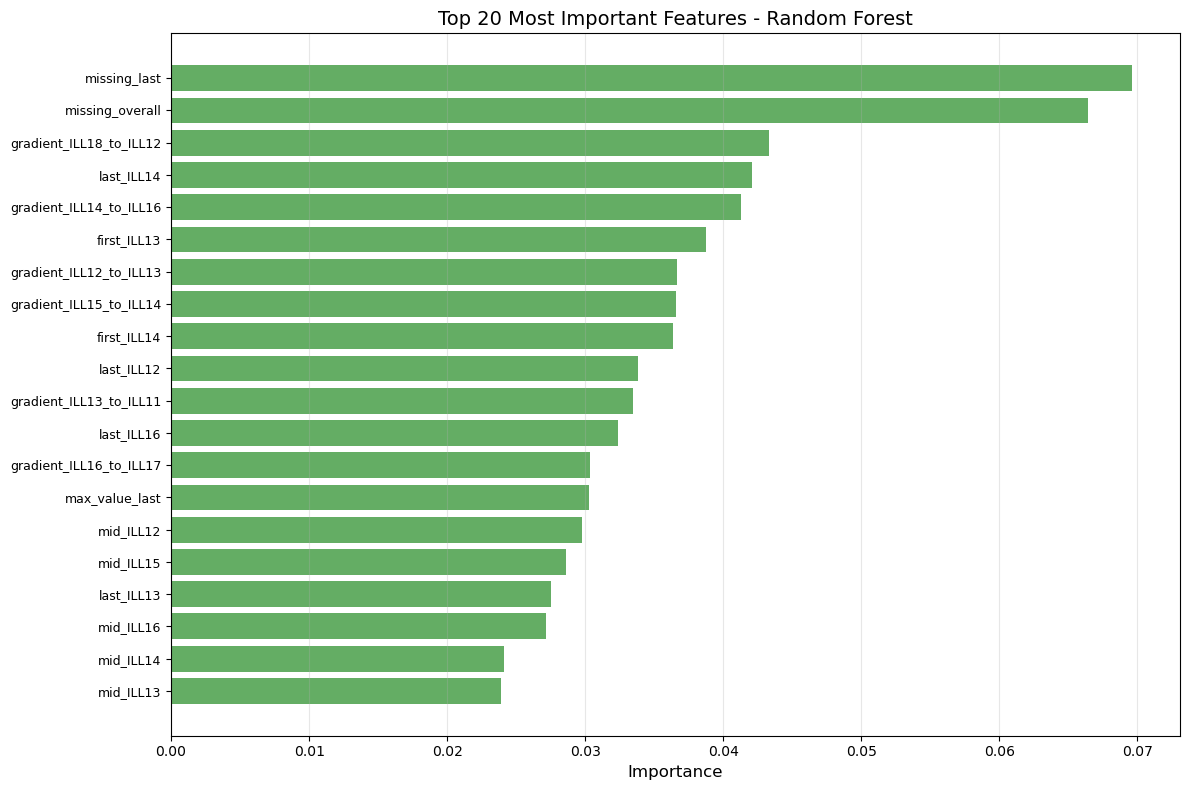


Feature Importance Statistics:
  Total features: 55
  Mean importance: 0.018182
  Std importance: 0.016616
  Max importance: 0.069604 (missing_last)
  Min importance: 0.000000 (first_ILL18)

Cumulative Importance:
  Features needed for 80% importance: 23
  Features needed for 90% importance: 30

Feature Category Analysis:
  Last Reading        : 0.1881 (18.8%)
  First Reading       : 0.1327 (13.3%)
  Mid Reading         : 0.1604 (16.0%)
  Changes             : 0.0240 (2.4%)
  Velocity            : 0.0327 (3.3%)
  Spatial Gradient    : 0.2331 (23.3%)
  Aggregate           : 0.2288 (22.9%)
Random Forest Key Results::
  Training Accuracy: 98.91%
  Test Accuracy: 51.52%

 Class Distribution Issues:
   Test set has limited class diversity: only 3 classes

Performance Comparison Table:
                      Model  Train_Accuracy  Train_Balanced_Acc  Train_F1_Macro  Train_F1_Weighted  Test_Accuracy  Test_Balanced_Acc  Test_F1_Macro  Test_F1_Weighted
Neural Network (LSTM+Dense)        0.70438

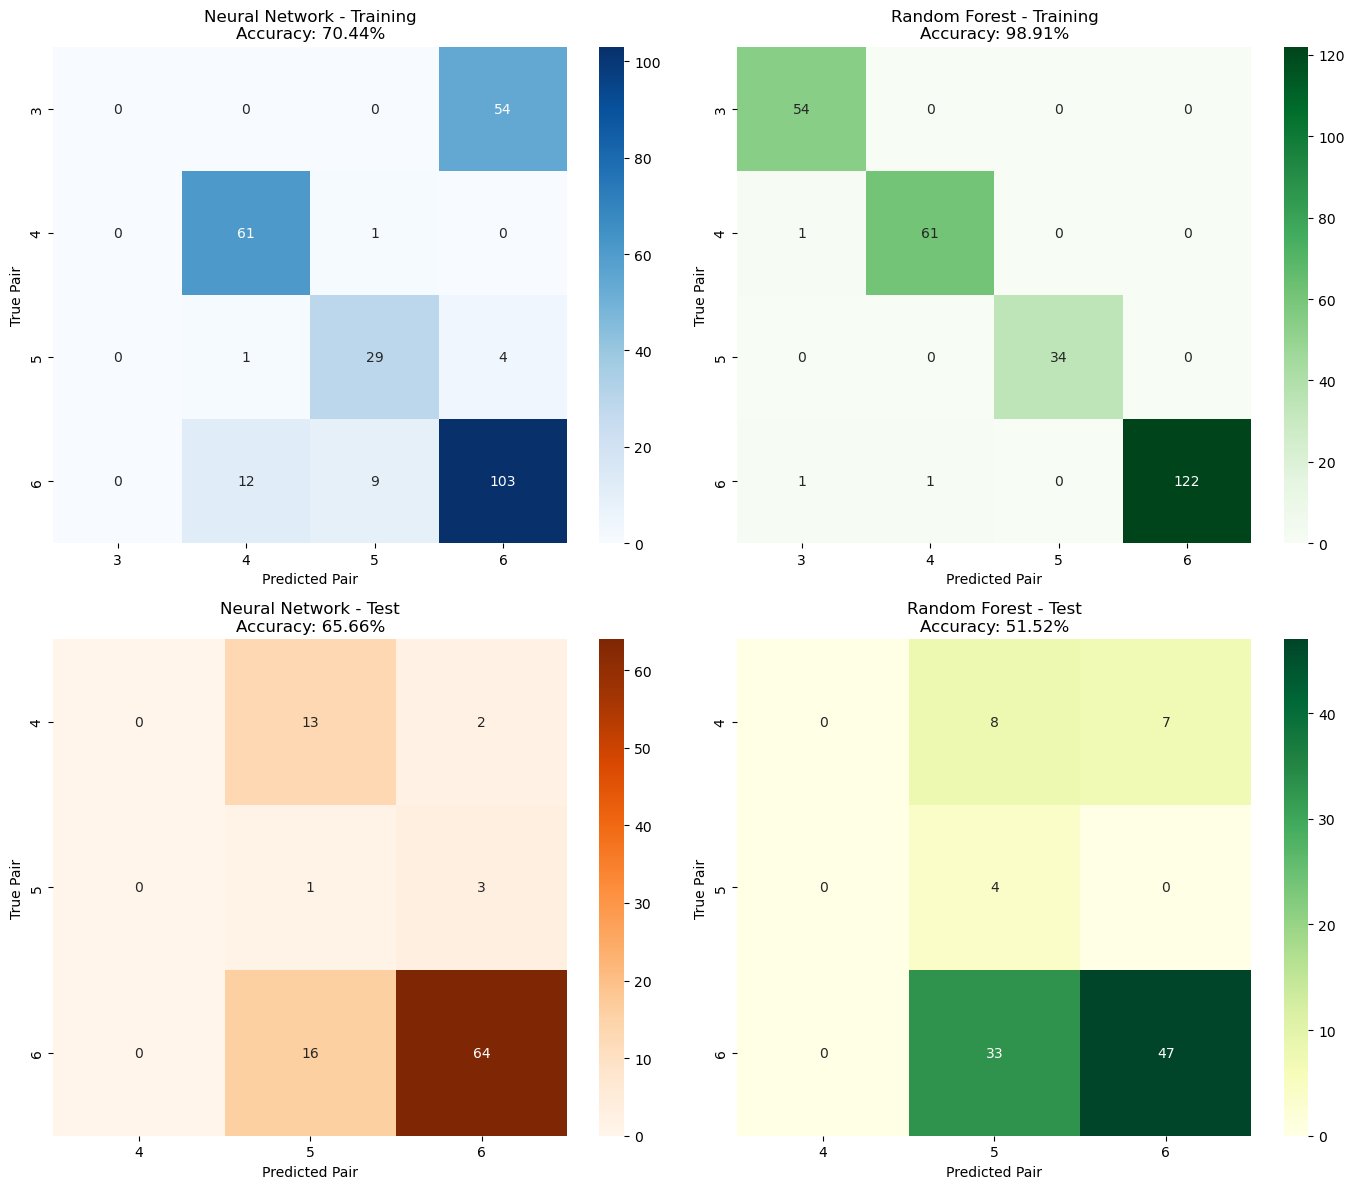

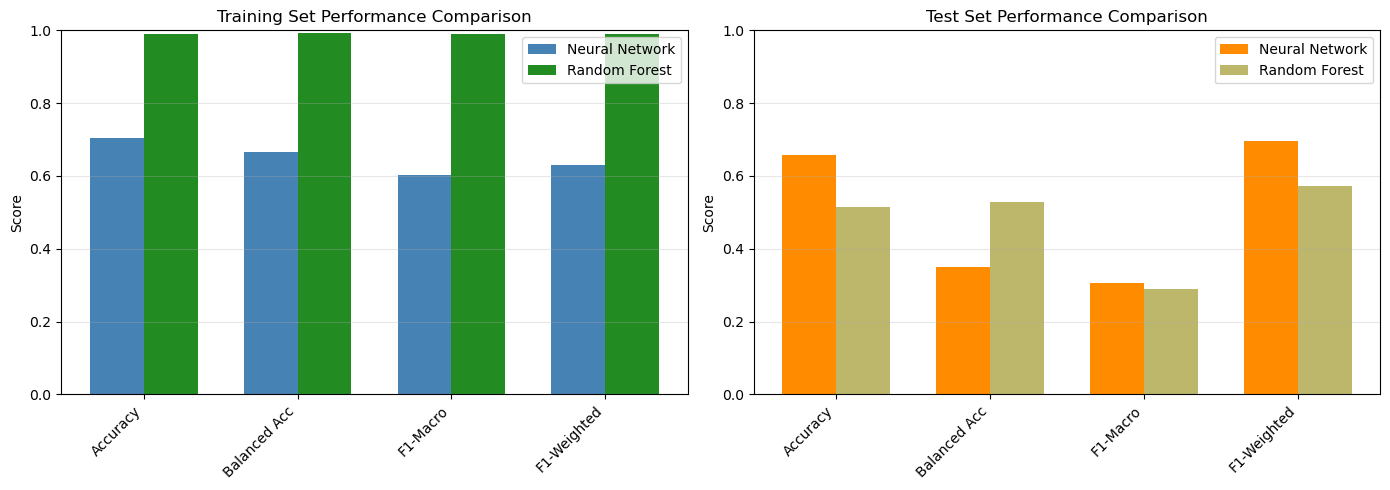

In [ ]:
# EVALUATE RANDOM FOREST ON TRAINING SET

y_train_pred_rf = rf_model.predict(X_train_enhanced)
y_train_pred_proba_rf = rf_model.predict_proba(X_train_enhanced)

train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_balanced_accuracy_rf = balanced_accuracy_score(y_train, y_train_pred_rf)

# Only compute F1 for classes that exist
train_f1_macro_rf = f1_score(y_train, y_train_pred_rf, average='macro', zero_division=0)
train_f1_weighted_rf = f1_score(y_train, y_train_pred_rf, average='weighted', zero_division=0)


print(f"\nOverall Metrics:")
print(f"  Accuracy: {train_accuracy_rf:.4f} ({train_accuracy_rf*100:.2f}%)")
print(f"  Balanced Accuracy: {train_balanced_accuracy_rf:.4f} ({train_balanced_accuracy_rf*100:.2f}%)")
print(f"  F1-Score (macro): {train_f1_macro_rf:.4f}")
print(f"  F1-Score (weighted): {train_f1_weighted_rf:.4f}")

print(f"\nClassification Report:")
# Use labels parameter to only include classes present in data
print(classification_report(
    y_train, 
    y_train_pred_rf,
    labels=all_classes,
    target_names=class_names,
    zero_division=0
))

# Confusion matrix
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf, labels=all_classes)
print(f"\nConfusion Matrix:")
print(f"Classes: {all_classes}")
print(cm_train_rf)


# EVALUATE RANDOM FOREST ON TEST SET

if X_test_enhanced is not None and len(X_test_enhanced) > 0:
    print("\n" + "="*70)
    print("Random Forest test set performance")
    print("="*70)
    
    y_test_pred_rf = rf_model.predict(X_test_enhanced)
    y_test_pred_proba_rf = rf_model.predict_proba(X_test_enhanced)
    
    test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
    test_balanced_accuracy_rf = balanced_accuracy_score(y_test, y_test_pred_rf)
    test_f1_macro_rf = f1_score(y_test, y_test_pred_rf, average='macro', zero_division=0)
    test_f1_weighted_rf = f1_score(y_test, y_test_pred_rf, average='weighted', zero_division=0)
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")
    print(f"  Balanced Accuracy: {test_balanced_accuracy_rf:.4f} ({test_balanced_accuracy_rf*100:.2f}%)")
    print(f"  F1-Score (macro): {test_f1_macro_rf:.4f}")
    print(f"  F1-Score (weighted): {test_f1_weighted_rf:.4f}")
    
    print(f"\nDetailed Classification Report:")
    test_classes = sorted(np.unique(y_test))
    test_class_names = [f'Pair {i}' for i in test_classes]
    
    # Check if test set has only one class
    if len(test_classes) == 1:
        print(f"\n WARNING: Test set contains only ONE class (Pair {test_classes[0]})!")
    else:
        print(classification_report(
            y_test, 
            y_test_pred_rf,
            labels=test_classes,
            target_names=test_class_names,
            zero_division=0
        ))
        
        # Confusion matrix
        cm_test_rf = confusion_matrix(y_test, y_test_pred_rf, labels=test_classes)
        print(f"\nConfusion Matrix:")
        print(f"Classes: {test_classes}")
        print(cm_test_rf)
    
    test_classes_var = test_classes
else:
    print("\n No test set available (0 windows created)")
    test_accuracy_rf = None
    cm_test_rf = None
    test_classes_var = None


# RANDOM FOREST SUMMARY TABLE

summary_data_rf = {
    'Dataset': [],
    'N_Samples': [],
    'N_Classes': [],
    'Accuracy': [],
    'Balanced_Acc': [],
    'F1_Macro': [],
    'F1_Weighted': []
}

# Training
summary_data_rf['Dataset'].append('Training')
summary_data_rf['N_Samples'].append(len(y_train))
summary_data_rf['N_Classes'].append(len(np.unique(y_train)))
summary_data_rf['Accuracy'].append(f"{train_accuracy_rf:.4f}")
summary_data_rf['Balanced_Acc'].append(f"{train_balanced_accuracy_rf:.4f}")
summary_data_rf['F1_Macro'].append(f"{train_f1_macro_rf:.4f}")
summary_data_rf['F1_Weighted'].append(f"{train_f1_weighted_rf:.4f}")

# Test
if test_accuracy_rf is not None:
    summary_data_rf['Dataset'].append('Test')
    summary_data_rf['N_Samples'].append(len(y_test))
    summary_data_rf['N_Classes'].append(len(np.unique(y_test)))
    summary_data_rf['Accuracy'].append(f"{test_accuracy_rf:.4f}")
    summary_data_rf['Balanced_Acc'].append(f"{test_balanced_accuracy_rf:.4f}")
    summary_data_rf['F1_Macro'].append(f"{test_f1_macro_rf:.4f}")
    summary_data_rf['F1_Weighted'].append(f"{test_f1_weighted_rf:.4f}")

summary_df_rf = pd.DataFrame(summary_data_rf)
print("\nRandom Forest Summary Table:")
print(summary_df_rf.to_string(index=False))


# SAMPLE PREDICTION ANALYSIS - RANDOM FOREST

print("\nRANDOM FOREST - Sample Prediction Analysis:")

if test_accuracy_rf is not None and len(test_classes_var) > 1:
    print("\nShowing first 5 test predictions:")
    
    # Get the class indices that the RF was trained on
    rf_classes = rf_model.classes_
    
    for i in range(min(5, len(y_test))):
        true_pair = y_test[i]
        pred_pair = y_test_pred_rf[i]
        
        # Map pred_pair to the index in the probability array
        if pred_pair in rf_classes:
            prob_idx = np.where(rf_classes == pred_pair)[0][0]
            confidence = y_test_pred_proba_rf[i, prob_idx]
        else:
            confidence = 0.0  # This shouldn't happen, but just in case
        
        # Get station names for this pair
        station_up = stations_sorted.iloc[pred_pair]['station']
        station_down = stations_sorted.iloc[pred_pair+1]['station']
        
        correct = "✓" if true_pair == pred_pair else "✗"
        print(f"  {i+1}. True: Pair {true_pair} | Pred: Pair {pred_pair} ({station_up}→{station_down}) | Conf: {confidence:.3f} {correct}")
elif test_accuracy_rf is not None:
    print("\n Test set has only one class - showing sample predictions:")
    print(f"  All {len(y_test)} samples are Pair {test_classes_var[0]}")
    print(f"  Model prediction for first sample:")
    pred_pair = y_test_pred_rf[0]
    
    # Map pred_pair to the index in the probability array
    rf_classes = rf_model.classes_
    if pred_pair in rf_classes:
        prob_idx = np.where(rf_classes == pred_pair)[0][0]
        confidence = y_test_pred_proba_rf[0, prob_idx]
    else:
        confidence = 0.0
    
    station_up = stations_sorted.iloc[pred_pair]['station']
    station_down = stations_sorted.iloc[pred_pair+1]['station']
    print(f"    Predicted: Pair {pred_pair} ({station_up}→{station_down}) with confidence {confidence:.3f}")


# FEATURE IMPORTANCE ANALYSIS (Random Forest specific)

print("Feature Importance Analysis")

# Create feature names matching the exact order in create_enhanced_features_with_nan
def create_feature_names(n_stations):
    """Create feature names matching the enhanced feature vector."""
    feature_names = []
    # Station names
    if 'stations_sorted' in globals():
        station_names = stations_sorted['station'].tolist()
    else:
        station_names = [f'Station_{i}' for i in range(n_stations)]
    
    # last_reading_clean - 8 features
    for station in station_names:
        feature_names.append(f'last_{station}')
    
    # first_reading_clean - 8 features
    for station in station_names:
        feature_names.append(f'first_{station}')
    
    # mid_reading_clean - 8 features
    for station in station_names:
        feature_names.append(f'mid_{station}')
    
    # score_changes - 8 features
    for station in station_names:
        feature_names.append(f'change_{station}')
    
    # score_velocity - 8 features
    for station in station_names:
        feature_names.append(f'velocity_{station}')
    
    # spatial_gradient - 7 features (n_stations - 1)
    for i in range(n_stations - 1):
        feature_names.append(f'gradient_{station_names[i]}_to_{station_names[i+1]}')
    
    # Scalar aggregate features
    feature_names.append('max_station_last')
    feature_names.append('max_station_first')
    feature_names.append('max_value_last')
    feature_names.append('max_value_first')
    feature_names.append('max_station_movement')
    feature_names.append('missing_last')
    feature_names.append('missing_first')
    feature_names.append('missing_overall')
    
    return feature_names


n_stations = 8 

feature_names = create_feature_names(n_stations)

# Verify the count matches
if len(feature_names) != X_train_enhanced.shape[1]:
    print(f"WARNING: Feature name count ({len(feature_names)}) doesn't match data shape ({X_train_enhanced.shape[1]})")
    feature_names = [f'Feature_{i}' for i in range(X_train_enhanced.shape[1])]
else:
    print(f" {len(feature_names)} features")

feature_importance = rf_model.feature_importances_
feature_indices = np.argsort(feature_importance)[::-1]

print(f"\nTop 20 Most Important Features:")
for i, idx in enumerate(feature_indices[:20], 1):
    print(f"  {i:2d}. {feature_names[idx]:40s}: {feature_importance[idx]:.6f}")

# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'Feature': [feature_names[i] for i in feature_indices[:20]],
    'Importance': feature_importance[feature_indices[:20]],
    'Index': feature_indices[:20]
})
print(f"\nTop 20 Features (Table):")
print(importance_df.to_string(index=False))

# Plot feature importance with names
fig, ax = plt.subplots(figsize=(12, 8))
top_n = 20
top_indices = feature_indices[:top_n]
top_names = [feature_names[idx] for idx in top_indices]
top_importance = feature_importance[top_indices]

y_pos = np.arange(top_n)
ax.barh(y_pos, top_importance, color='forestgreen', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(top_names, fontsize=9)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features - Random Forest', fontsize=14)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.savefig('feature_importance_rf.pdf', dpi=300)
plt.show()

# Additional statistics
print(f"\nFeature Importance Statistics:")
print(f"  Total features: {len(feature_importance)}")
print(f"  Mean importance: {feature_importance.mean():.6f}")
print(f"  Std importance: {feature_importance.std():.6f}")
print(f"  Max importance: {feature_importance.max():.6f} ({feature_names[feature_importance.argmax()]})")
print(f"  Min importance: {feature_importance.min():.6f} ({feature_names[feature_importance.argmin()]})")

# Cumulative importance
cumsum_importance = np.cumsum(feature_importance[feature_indices])
n_features_80 = np.argmax(cumsum_importance >= 0.80) + 1
n_features_90 = np.argmax(cumsum_importance >= 0.90) + 1

print(f"\nCumulative Importance:")
print(f"  Features needed for 80% importance: {n_features_80}")
print(f"  Features needed for 90% importance: {n_features_90}")

# Feature category analysis
print(f"\nFeature Category Analysis:")
categories = {
    'Last Reading': [i for i, name in enumerate(feature_names) if name.startswith('last_')],
    'First Reading': [i for i, name in enumerate(feature_names) if name.startswith('first_')],
    'Mid Reading': [i for i, name in enumerate(feature_names) if name.startswith('mid_')],
    'Changes': [i for i, name in enumerate(feature_names) if name.startswith('change_')],
    'Velocity': [i for i, name in enumerate(feature_names) if name.startswith('velocity_')],
    'Spatial Gradient': [i for i, name in enumerate(feature_names) if name.startswith('gradient_')],
    'Aggregate': [i for i, name in enumerate(feature_names) if name.startswith('max_') or name.startswith('missing_')]
}

for category, indices in categories.items():
    if len(indices) > 0:
        category_importance = feature_importance[indices].sum()
        print(f"  {category:20s}: {category_importance:.4f} ({category_importance/feature_importance.sum()*100:.1f}%)")


# RANDOM FOREST FINAL SUMMARY

print("Random Forest Key Results::")
print(f"  Training Accuracy: {train_accuracy_rf*100:.2f}%")
if test_accuracy_rf is not None:
    if len(test_classes_var) > 1:
        print(f"  Test Accuracy: {test_accuracy_rf*100:.2f}%")
    else:
        print(f"  Test Accuracy: N/A (only 1 class present)")

print("\n Class Distribution Issues:")
if y_test is not None and len(test_classes_var) == 1:
    print("  CRITICAL: Test set contains only one class!")
    print(f"     All {len(y_test)} test samples are Pair {test_classes_var[0]}")
elif y_test is not None:
    n_test_classes = len(test_classes_var)
    if n_test_classes < 4:
        print(f"   Test set has limited class diversity: only {n_test_classes} classes")
    else:
        print(f"  Good test set: {n_test_classes} classes present")


# MODEL COMPARISON: NEURAL NETWORK vs RANDOM FOREST



# Create comparison dataframe
comparison_data = {
    'Model': ['Neural Network (LSTM+Dense)', 'Random Forest'],
    'Train_Accuracy': [train_accuracy, train_accuracy_rf],
    'Train_Balanced_Acc': [train_balanced_accuracy, train_balanced_accuracy_rf],
    'Train_F1_Macro': [train_f1_macro, train_f1_macro_rf],
    'Train_F1_Weighted': [train_f1_weighted, train_f1_weighted_rf]
}

if test_accuracy is not None and test_accuracy_rf is not None:
    comparison_data['Test_Accuracy'] = [test_accuracy, test_accuracy_rf]
    comparison_data['Test_Balanced_Acc'] = [test_balanced_accuracy, test_balanced_accuracy_rf]
    comparison_data['Test_F1_Macro'] = [test_f1_macro, test_f1_macro_rf]
    comparison_data['Test_F1_Weighted'] = [test_f1_weighted, test_f1_weighted_rf]

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Comparison Table:")
print(comparison_df.to_string(index=False))

# Calculate differences
print("\nPerformance Differences (NN - RF):")
print(f"  Training Accuracy: {(train_accuracy - train_accuracy_rf)*100:+.2f}%")
print(f"  Training Balanced Acc: {(train_balanced_accuracy - train_balanced_accuracy_rf)*100:+.2f}%")
print(f"  Training F1-Macro: {(train_f1_macro - train_f1_macro_rf):+.4f}")

if test_accuracy is not None and test_accuracy_rf is not None:
    print(f"  Test Accuracy: {(test_accuracy - test_accuracy_rf)*100:+.2f}%")
    print(f"  Test Balanced Acc: {(test_balanced_accuracy - test_balanced_accuracy_rf)*100:+.2f}%")
    print(f"  Test F1-Macro: {(test_f1_macro - test_f1_macro_rf):+.4f}")

# Determine winner
print("\nModel Performance Summary:")
if test_accuracy is not None and test_accuracy_rf is not None:
    if test_accuracy > test_accuracy_rf:
        winner = "Neural Network"
        margin = (test_accuracy - test_accuracy_rf) * 100
    elif test_accuracy_rf > test_accuracy:
        winner = "Random Forest"
        margin = (test_accuracy_rf - test_accuracy) * 100
    else:
        winner = "TIE"
        margin = 0
    
    if winner != "TIE":
        print(f"  Best Test Accuracy: {winner} (+{margin:.2f}%)")
    else:
        print(f"  Test Accuracy: TIE")
    
    # Check for overfitting
    nn_overfit = (train_accuracy - test_accuracy) * 100
    rf_overfit = (train_accuracy_rf - test_accuracy_rf) * 100
    
    print(f"\n  Overfitting Analysis (Train - Test):")
    print(f"    Neural Network: {nn_overfit:.2f}%")
    print(f"    Random Forest: {rf_overfit:.2f}%")
    
    if abs(nn_overfit) < abs(rf_overfit):
        print(f"    Neural Network shows better generalization")
    elif abs(rf_overfit) < abs(nn_overfit):
        print(f"    Random Forest shows better generalization")
    else:
        print(f"    Both models generalize similarly")


# Visualization: Side-by-side comparison
if test_accuracy is not None and test_accuracy_rf is not None and len(test_classes_var) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Training confusion matrices
    ax = axes[0, 0]
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
    ax.set_xlabel('Predicted Pair')
    ax.set_ylabel('True Pair')
    ax.set_title(f'Neural Network - Training\nAccuracy: {train_accuracy:.2%}')
    ax.set_xticklabels(all_classes)
    ax.set_yticklabels(all_classes)
    
    ax = axes[0, 1]
    sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens', ax=ax, cbar=True)
    ax.set_xlabel('Predicted Pair')
    ax.set_ylabel('True Pair')
    ax.set_title(f'Random Forest - Training\nAccuracy: {train_accuracy_rf:.2%}')
    ax.set_xticklabels(all_classes)
    ax.set_yticklabels(all_classes)
    
    # Test confusion matrices
    ax = axes[1, 0]
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', ax=ax, cbar=True)
    ax.set_xlabel('Predicted Pair')
    ax.set_ylabel('True Pair')
    ax.set_title(f'Neural Network - Test\nAccuracy: {test_accuracy:.2%}')
    ax.set_xticklabels(test_classes_var)
    ax.set_yticklabels(test_classes_var)
    
    ax = axes[1, 1]
    sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='YlGn', ax=ax, cbar=True)
    ax.set_xlabel('Predicted Pair')
    ax.set_ylabel('True Pair')
    ax.set_title(f'Random Forest - Test\nAccuracy: {test_accuracy_rf:.2%}')
    ax.set_xticklabels(test_classes_var)
    ax.set_yticklabels(test_classes_var)
    
    plt.tight_layout()
    plt.savefig('model_comparison_confusion_matrices.pdf', dpi=300)
    plt.show()

# Bar chart comparison
if test_accuracy is not None and test_accuracy_rf is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    metrics = ['Accuracy', 'Balanced Acc', 'F1-Macro', 'F1-Weighted']
    nn_train = [train_accuracy, train_balanced_accuracy, train_f1_macro, train_f1_weighted]
    rf_train = [train_accuracy_rf, train_balanced_accuracy_rf, train_f1_macro_rf, train_f1_weighted_rf]
    nn_test = [test_accuracy, test_balanced_accuracy, test_f1_macro, test_f1_weighted]
    rf_test = [test_accuracy_rf, test_balanced_accuracy_rf, test_f1_macro_rf, test_f1_weighted_rf]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    # Training comparison
    ax = axes[0]
    ax.bar(x - width/2, nn_train, width, label='Neural Network', color='steelblue')
    ax.bar(x + width/2, rf_train, width, label='Random Forest', color='forestgreen')
    ax.set_ylabel('Score')
    ax.set_title('Training Set Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    # Test comparison
    ax = axes[1]
    ax.bar(x - width/2, nn_test, width, label='Neural Network', color='darkorange')
    ax.bar(x + width/2, rf_test, width, label='Random Forest', color='darkkhaki')
    ax.set_ylabel('Score')
    ax.set_title('Test Set Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('model_comparison_metrics.pdf', dpi=300)
    plt.show()
